# Scrapping B3 companies papers performance

In [4]:
# inicializando o Selenium e pandas
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.select import Select
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import time
from datetime import datetime
import concurrent.futures
dia = datetime.now().strftime('%Y-%m-%d')

chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--start-maximized')
chrome_options.add_argument('--user-agent=Mozilla/5.0 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36') # TROCANDO O USER-AGENT Mozilla/5.0 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.53 Safari/537.36
chrome_options.add_argument('--ignore-certificate-errors')
chrome_options.add_argument('--window-size=1024x768')
wd = webdriver.Chrome('chromedriver',options=chrome_options, service_args=['--verbose', '--log-path=/tmp/chromedriver.log'])

# Importando teclas de comando
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

# deletando cookies
wd.delete_all_cookies

<bound method WebDriver.delete_all_cookies of <selenium.webdriver.chrome.webdriver.WebDriver (session="966a9424a6b856ae371c6d351139d2ca")>>

In [2]:
# Acesso à página objeto de retirada de dados
wd.implicitly_wait(2)
wd.get("https://www.fundamentus.com.br/detalhes.php?papel=")

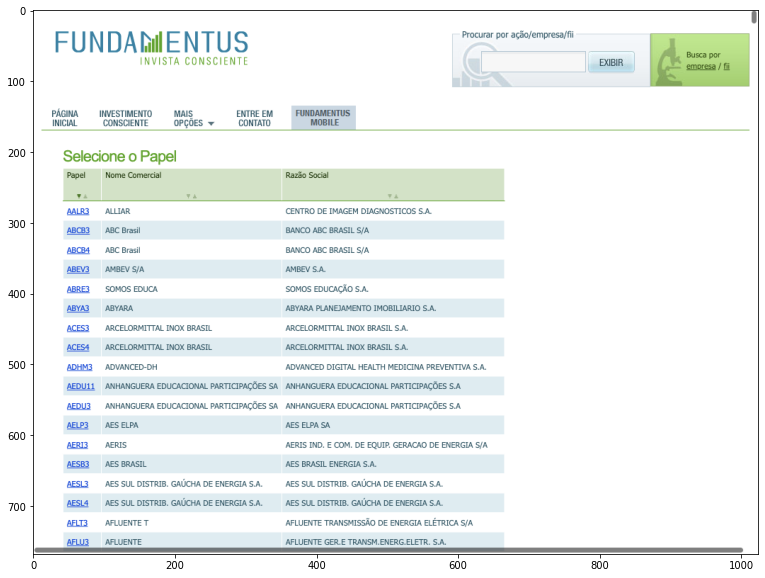

In [3]:
######## Visualizando Navegação Durante o processo de coleta ########

figure = wd.find_elements(By.XPATH, '/html')[0].screenshot_as_png
im = Image.open(BytesIO(figure))
plt.figure(figsize=(15,10))
plt.imshow(im)
plt.show()

In [4]:
paper_list = WebDriverWait(wd, 10).until(
        EC.presence_of_all_elements_located((By.XPATH, '//*[@id="test1"]/tbody/tr/td/a'))
    )
paper_code = [name.get_attribute('text') for name in paper_list]

In [5]:
paper_code[0:5]

['AALR3 ', 'ABCB3', 'ABCB4', 'ABEV3', 'ABRE3']

In [6]:
name_list = WebDriverWait(wd, 10).until(
        EC.presence_of_all_elements_located((By.XPATH, '//*[@id="test1"]/tbody/tr/td'))
    )
paper_name = [name.text for name in name_list]

In [7]:
len(paper_name)

3093

In [8]:
# makeing papers dataframe

df = pd.DataFrame()
lista_code = []
lista_nome = []
lista_description = []
for i in range(0,len(paper_name),3):
    lista_code.append(paper_name[i])
    lista_nome.append(paper_name[i+1])
    lista_description.append(paper_name[i+2])

df['code'] = lista_code
df['name'] = lista_nome
df['description'] = lista_description
df.head()

,code,name,description
0,AALR3,ALLIAR,CENTRO DE IMAGEM DIAGNOSTICOS S.A.
1,ABCB3,ABC Brasil,BANCO ABC BRASIL S/A
2,ABCB4,ABC Brasil,BANCO ABC BRASIL S/A
3,ABEV3,AMBEV S/A,AMBEV S.A.
4,ABRE3,SOMOS EDUCA,SOMOS EDUCAÇÃO S.A.


In [79]:
# Acesso à página objeto de retirada de dados
wd.get(f"https://www.fundamentus.com.br/detalhes.php?papel={df['code'][1]}")

In [9]:
def paper_colect(code):
    # Acesso à página objeto de retirada de dados
    wd.get(f"https://www.fundamentus.com.br/detalhes.php?papel={code}")
    paper_data = WebDriverWait(wd, 10).until(
        EC.presence_of_all_elements_located((By.XPATH, '/html/body/div/div/table/tbody/tr/td'))
    )
    paper = [name.text for name in paper_data]
    del_expression = ['Oscilações', 'Indicadores fundamentalistas', 'Dados Balanço Patrimonial', 'Dados demonstrativos de resultados', 'Últimos 12 meses', 'Últimos 3 meses']
    [paper.remove(i) for i in del_expression];
    paper_df = pd.DataFrame()
    attr_list = []
    value_list = []
    for i in range(0,len(paper),2):
            attr_list.append(paper[i])
            value_list.append(paper[i+1])

    attr_list[-6] = '12m Receita Líquida'
    attr_list[-5] = '3m Receita Líquida'
    attr_list[-4] = '12m EBIT'
    attr_list[-3] = '3m EBIT'
    attr_list[-2] = '12m Lucro Líquido'
    attr_list[-1] = '3m Lucro Líquido'
    df = pd.DataFrame([value_list], columns=attr_list)
    df['data_cap'] = dia
    if df['Cotação'][0] == '0,00':
        exit
    else:
        return df

In [93]:
b3_df = pd.DataFrame()
for code in df['code']:
    try:
        b3_df = pd.concat([b3_df, paper_colect(code)], axis=0, ignore_index=True)
    except:
        pass

In [97]:
b3_df.tail()

,Papel,Cotação,Tipo,Data últ cot,Empresa,Min 52 sem,Setor,Max 52 sem,Subsetor,Vol $ méd (2m),...,12m Lucro Líquido,3m Lucro Líquido,data_cap,Depósitos,Cart. de Crédito,2017,2016,2015,2014,2013
354,ELPL5,"30,50",PNA,20/12/2010,AES ELETROPAULO PNA,"0,00",Energia Elétrica,"0,00",Energia Elétrica,0,...,1.724.920.000,352.662.000,2023-08-20,NaN,NaN,"0,00%","0,00%","0,00%","0,00%","0,00%"
355,ELPL6,"30,20",PNB,20/12/2010,AES ELETROPAULO PNB,"0,00",Energia Elétrica,"0,00",Energia Elétrica,0,...,1.724.920.000,352.662.000,2023-08-20,NaN,NaN,"0,00%","0,00%","0,00%","0,00%","0,00%"
356,ELUM3,"36,00",ON,10/06/2008,ELUMA ON,"0,00",,"0,00",,0,...,59.690.000,15.297.000,2023-08-20,NaN,NaN,"0,00%","0,00%","0,00%","0,00%","0,00%"
357,ELUM4,"47,90",PN,23/04/2010,ELUMA PN,"0,00",,"0,00",,0,...,59.690.000,15.297.000,2023-08-20,NaN,NaN,"0,00%","0,00%","0,00%","0,00%","0,00%"
358,EMAE4,"57,13",PN,18/08/2023,EMAE PN,"33,80",Energia Elétrica,"69,20",Energia Elétrica,190.807,...,69.337.000,37.848.000,2023-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# função para limpar ponto flutuante em números registros '-'

def float_clean(x: str):
    if type(x) == int:
        return 0.0
    elif len(x) > 6:
        x = x.replace('.', '')
        return float(x.replace(',', '.'))
    elif len(x) > 1:
        return float(x.replace(',', '.'))
    else:
        return float(x.replace('-', '0').replace(',', '.'))

In [17]:
# Lendo dataframe e limpando

#b3_df = pd.read_csv('b3_data.csv', decimal=',')
b3_df['Setor'].fillna('sem_nome', inplace=True)
b3_df['Subsetor'].fillna('sem_nome', inplace=True)
b3_df.fillna(0, inplace=True)
b3_df = b3_df.iloc[:,1:]
b3_df.replace(to_replace='%', value='', regex=True, inplace=True)
b3_df['Data últ cot'] = pd.to_datetime(b3_df['Data últ cot'], dayfirst=True)
b3_df['data_cap'] = pd.to_datetime(b3_df['data_cap'])
b3_df['Nro. Ações'] = b3_df['Nro. Ações'].str.replace('.', '').astype(int)
b3_df['Vol $ méd (2m)'] = b3_df['Vol $ méd (2m)'].str.replace('.', '').astype(int)
b3_df['Valor de mercado'] = b3_df['Valor de mercado'].str.replace('.', '').astype(int)
b3_df['Valor da firma'] = b3_df['Valor da firma'].str.replace('-', '0').str.replace('.', '').astype(int)
b3_df['Últ balanço processado'] = pd.to_datetime(b3_df['Últ balanço processado'],dayfirst=True)
b3_df.head()

/var/folders/39/nhpmjqr92_n_phmv38r6nym80000gn/T/ipykernel_40544/2527622804.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  b3_df['Nro. Ações'] = b3_df['Nro. Ações'].str.replace('.', '').astype(int)
/var/folders/39/nhpmjqr92_n_phmv38r6nym80000gn/T/ipykernel_40544/2527622804.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  b3_df['Vol $ méd (2m)'] = b3_df['Vol $ méd (2m)'].str.replace('.', '').astype(int)
/var/folders/39/nhpmjqr92_n_phmv38r6nym80000gn/T/ipykernel_40544/2527622804.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings 

,Papel,Cotação,Tipo,Data últ cot,Empresa,Min 52 sem,Setor,Max 52 sem,Subsetor,Vol $ méd (2m),...,Depósitos,Cart. de Crédito,2017,2016,2015,2014,2013,2012,2011,2010
0,AALR3,"10,68",ON NM,2023-08-22,ALLIAR ON NM,10.68,Serv.Méd.Hospit. Análises e Diagnósticos,24.30,Serv.Méd.Hospit. Análises e Diagnósticos,9217100,...,0,0,0,0,0,0,0,0,0,0
1,ABCB4,"18,62",PN N2,2023-08-22,ABC Brasil PN N2,15.28,Intermediários Financeiros,21.26,Bancos,15853300,...,0,0,0,0,0,0,0,0,0,0
2,ABEV3,"14,42",ON,2023-08-22,AMBEV S/A ON,12.86,Bebidas,16.03,Cervejas e Refrigerantes,341701000,...,0,0,0,0,0,0,0,0,0,0
3,ABYA3,"4,91",ON NM,2010-02-11,ABYARA ON NM,0.00,Construção Civil,0.00,Incorporações,0,...,0,0,"0,00","0,00","0,00","0,00","0,00",0,0,0
4,ACES3,"95,27",ON,2008-04-18,ARCELORMITTAL INOX BRASIL ON,0.00,Siderurgia e Metalurgia,0.00,Siderurgia,0,...,0,0,"0,00","0,00","0,00","0,00","0,00",0,0,0


In [18]:
for column in b3_df.iloc[:,0:].columns:
    if b3_df[column].dtype == 'object':
        try:
            b3_df[column] = b3_df[column].apply(float_clean)
        except:
            pass

In [19]:
b3_df.iloc[:,0:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 70 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Papel                   950 non-null    object        
 1   Cotação                 950 non-null    float64       
 2   Tipo                    950 non-null    object        
 3   Data últ cot            950 non-null    datetime64[ns]
 4   Empresa                 950 non-null    object        
 5   Min 52 sem              950 non-null    float64       
 6   Setor                   950 non-null    object        
 7   Max 52 sem              950 non-null    float64       
 8   Subsetor                950 non-null    object        
 9   Vol $ méd (2m)          950 non-null    int64         
 10  Valor de mercado        950 non-null    int64         
 11  Últ balanço processado  950 non-null    datetime64[ns]
 12  Valor da firma          950 non-null    int64     

In [12]:
b3_df.to_csv('b3_data_clean.csv')

In [20]:
b3_df.iloc[:,5:15]

,Min 52 sem,Setor,Max 52 sem,Subsetor,Vol $ méd (2m),Valor de mercado,Últ balanço processado,Valor da firma,Nro. Ações,Dia
0,10.68,Serv.Méd.Hospit. Análises e Diagnósticos,24.30,Serv.Méd.Hospit. Análises e Diagnósticos,9217100,1263370000,2023-06-30,2158990000,118293000,-1.11
1,15.28,Intermediários Financeiros,21.26,Bancos,15853300,4209800000,2023-06-30,0,226090000,0.59
2,12.86,Bebidas,16.03,Cervejas e Refrigerantes,341701000,227170000000,2023-06-30,218732000000,15753800000,0.77
3,0.00,Construção Civil,0.00,Incorporações,0,515088000,2010-03-31,868691000,104906000,0.00
4,0.00,Siderurgia e Metalurgia,0.00,Siderurgia,0,7080470000,2007-12-31,6437160000,74320000,0.00
...,...,...,...,...,...,...,...,...,...,...
945,14.89,Comércio,35.08,Material de Transporte,115374,1277430000,2023-06-30,1275120000,36414700,1.83
946,0.00,"Tecidos, Vestuário e Calçados",0.00,Fios e Tecidos,0,609360000,2016-06-30,1768760000,24000000,0.00
947,49.25,Transporte,68.21,Serviços de Apoio e Armazenagem,0,2110500000,2021-06-30,4437980000,31500000,0.00
948,6.47,Diversos,23.70,Serviços Educacionais,113716000,6790690000,2023-06-30,11057200000,309089000,3.05


In [21]:
# importando lib
import sqlalchemy

# configuração do databse MySQL
db_host = '192.168.0.121'
db_user = 'root'
db_password = 'root'
db_name = 'casa'

# URL de conexão ao database
db_url = f'mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}'

# Criando engine
engine = sqlalchemy.create_engine(db_url)

In [22]:
# Gravando dados na tabela produtos
b3_df.to_sql('b3', con=engine, index=False, if_exists='append')

In [ ]:
wd.quit()